<a href="https://colab.research.google.com/github/JohnathanDoe22/Golden-cross-analysis/blob/main/Golden_Cross_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Investment Strategy Backtesting Analysis

Performance Summary:
                                    total_return  annualized_return  \
strategy                                                              
Balanced Portfolio (Monthly Rebal)        394.66              22.68   
Tactical Strategy                         515.66              23.28   

                                    volatility  sharpe_ratio  max_drawdown  
strategy                                                                    
Balanced Portfolio (Monthly Rebal)       20.12          0.98        -31.26  
Tactical Strategy                        20.63          0.98        -32.66  


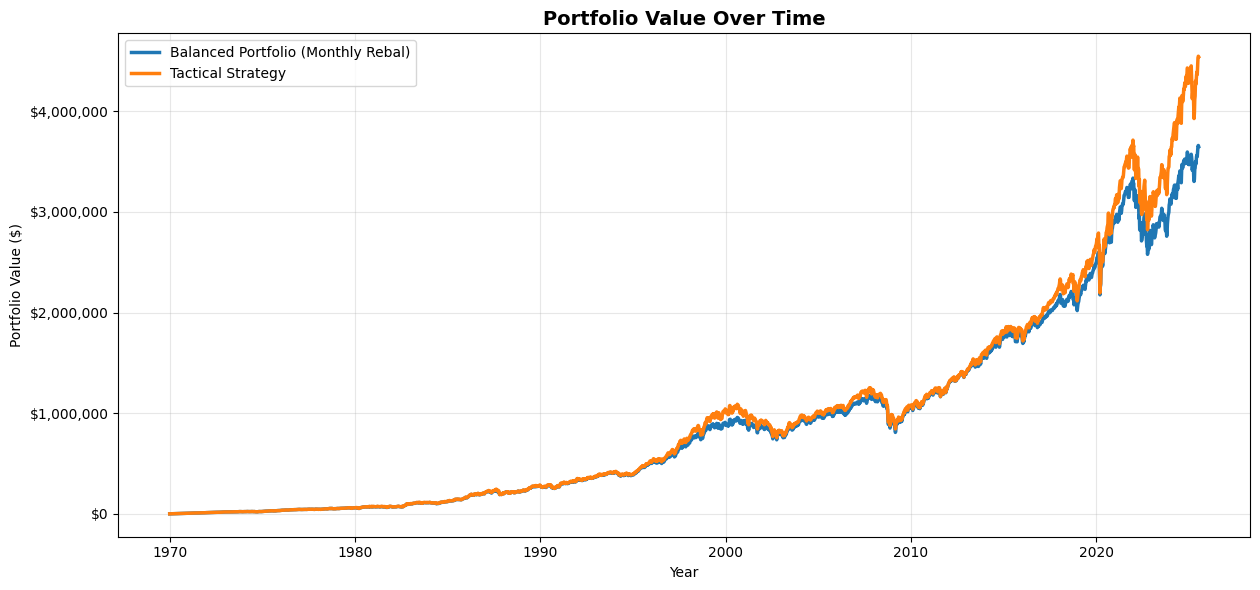

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

STOCK_TICKER = "^GSPC"
BOND_TICKER = "^TNX"
START_DATE = "1970-01-01"
INTERVAL = "1wk"
INITIAL_WEEKLY_CONTRIB = 100.0
CONTRIB_GROWTH_RATE = 0.03
BOND_DURATION = 10

# Tactical Strategy Parameters
MIN_STOCK_PCT = 55.0
MAX_STOCK_PCT = 65.0
BULL_CONTRIB_SPLIT = 0.80
BEAR_CONTRIB_SPLIT = 0.40
SHORT_EMA = 13
LONG_EMA = 52

print("Investment Strategy Backtesting Analysis")
print("="*50)

# Data Download and Prep
stock_prices = yf.download(STOCK_TICKER, start=START_DATE, interval=INTERVAL, auto_adjust=True, progress=False)["Close"]
rate_data = yf.download(BOND_TICKER, start=START_DATE, interval=INTERVAL, auto_adjust=True, progress=False)["Close"]
bond_prices = 100 / (1 + rate_data / 100)**BOND_DURATION

common_df = pd.concat([stock_prices, bond_prices], axis=1).dropna()
stock_prices = common_df.iloc[:, 0]
bond_prices = common_df.iloc[:, 1]

# --- Performance Metrics Function ---
def calculate_performance_metrics(final_value, total_invested, portfolio_values):
    """Calculate standard investment performance metrics"""

    total_return = (final_value / total_invested - 1) * 100
    weekly_returns = portfolio_values.pct_change().dropna()

    mean_weekly_return = weekly_returns.mean()
    annualized_return = (1 + mean_weekly_return)**52 - 1
    annualized_volatility = weekly_returns.std() * np.sqrt(52)

    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility > 0 else 0

    cumulative_values = portfolio_values.copy()
    running_max = cumulative_values.expanding().max()
    drawdown = (cumulative_values - running_max) / running_max
    max_drawdown = drawdown.min() * 100

    return {
        'total_return': total_return,
        'annualized_return': annualized_return * 100,
        'volatility': annualized_volatility * 100,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'final_value': final_value,
        'portfolio_values': portfolio_values
    }

# --- Strategy Backtesting Functions ---
def backtest_static_allocation(stock_pct, bond_pct, strategy_name):
    """Static allocation with no rebalancing"""
    stock_shares = 0.0
    bond_shares = 0.0
    total_invested = 0.0
    portfolio_values = []

    for i in range(len(stock_prices)):
        stock_price = stock_prices.iloc[i]
        bond_price = bond_prices.iloc[i]
        years_elapsed = i / 52.0
        weekly_contribution = INITIAL_WEEKLY_CONTRIB * (1 + CONTRIB_GROWTH_RATE)**years_elapsed
        total_invested += weekly_contribution

        stock_shares += (weekly_contribution * stock_pct) / stock_price
        bond_shares += (weekly_contribution * bond_pct) / bond_price

        current_value = stock_shares * stock_price + bond_shares * bond_price
        portfolio_values.append(current_value)

    portfolio_values = pd.Series(portfolio_values, index=stock_prices.index)
    final_stock_value = stock_shares * stock_prices.iloc[-1]
    final_bond_value = bond_shares * bond_prices.iloc[-1]
    final_value = final_stock_value + final_bond_value
    final_stock_allocation = (final_stock_value / final_value) * 100 if final_value > 0 else 0

    metrics = calculate_performance_metrics(final_value, total_invested, portfolio_values)
    metrics['strategy'] = strategy_name
    metrics['final_stock_allocation'] = final_stock_allocation

    return metrics

def backtest_balanced_portfolio():
    """Balanced 60/40 portfolio with monthly rebalancing"""
    stock_shares = 0.0
    bond_shares = 0.0
    total_invested = 0.0
    portfolio_values = []

    for i in range(len(stock_prices)):
        stock_price = stock_prices.iloc[i]
        bond_price = bond_prices.iloc[i]
        years_elapsed = i / 52.0
        weekly_contribution = INITIAL_WEEKLY_CONTRIB * (1 + CONTRIB_GROWTH_RATE)**years_elapsed
        total_invested += weekly_contribution

        # Add weekly contribution at target allocation
        stock_shares += (weekly_contribution * 0.60) / stock_price
        bond_shares += (weekly_contribution * 0.40) / bond_price

        # Rebalance monthly
        if (i + 1) % 4 == 0 and i > 0:
            current_value = (stock_shares * stock_price) + (bond_shares * bond_price)
            target_stock_value = current_value * 0.60
            target_bond_value = current_value * 0.40
            stock_shares = target_stock_value / stock_price
            bond_shares = target_bond_value / bond_price

        current_value = stock_shares * stock_price + bond_shares * bond_price
        portfolio_values.append(current_value)

    portfolio_values = pd.Series(portfolio_values, index=stock_prices.index)
    final_stock_value = stock_shares * stock_prices.iloc[-1]
    final_bond_value = bond_shares * bond_prices.iloc[-1]
    final_value = final_stock_value + final_bond_value
    final_stock_allocation = (final_stock_value / final_value) * 100 if final_value > 0 else 0

    metrics = calculate_performance_metrics(final_value, total_invested, portfolio_values)
    metrics['strategy'] = 'Balanced Portfolio (Monthly Rebal)'
    metrics['final_stock_allocation'] = final_stock_allocation

    return metrics

def backtest_tactical_strategy():
    """Tactical allocation strategy with trend following"""
    ema_short = stock_prices.ewm(span=SHORT_EMA, adjust=False).mean()
    ema_long = stock_prices.ewm(span=LONG_EMA, adjust=False).mean()
    is_bull_market = (ema_short > ema_long)

    stock_shares, bond_shares, total_invested = 0.0, 0.0, 0.0
    portfolio_values = []

    for i in range(len(stock_prices)):
        stock_price = stock_prices.iloc[i]
        bond_price = bond_prices.iloc[i]
        current_stock_value = stock_shares * stock_price
        current_bond_value = bond_shares * bond_price
        current_total_value = current_stock_value + current_bond_value
        current_stock_allocation = (current_stock_value / current_total_value * 100) if current_total_value > 0 else 0

        # Tactical allocation logic
        if current_stock_allocation > MAX_STOCK_PCT and current_total_value > 0:
            stock_contribution_pct = 0.0
        elif current_stock_allocation < MIN_STOCK_PCT and current_total_value > 0:
            stock_contribution_pct = 1.0
        else:
            if is_bull_market.iloc[i]:
                stock_contribution_pct = BULL_CONTRIB_SPLIT
            else:
                stock_contribution_pct = BEAR_CONTRIB_SPLIT

        years_elapsed = i / 52.0
        weekly_contribution = INITIAL_WEEKLY_CONTRIB * (1 + CONTRIB_GROWTH_RATE)**years_elapsed
        total_invested += weekly_contribution
        stock_shares += (weekly_contribution * stock_contribution_pct) / stock_price
        bond_shares += (weekly_contribution * (1 - stock_contribution_pct)) / bond_price

        current_value = stock_shares * stock_price + bond_shares * bond_price
        portfolio_values.append(current_value)

    portfolio_values = pd.Series(portfolio_values, index=stock_prices.index)
    final_stock_value = stock_shares * stock_prices.iloc[-1]
    final_bond_value = bond_shares * bond_prices.iloc[-1]
    final_value = final_stock_value + final_bond_value
    final_stock_allocation = (final_stock_value / final_value) * 100 if final_value > 0 else 0

    metrics = calculate_performance_metrics(final_value, total_invested, portfolio_values)
    metrics['strategy'] = 'Tactical Strategy'
    metrics['final_stock_allocation'] = final_stock_allocation

    return metrics

# --- Execute Backtests ---
balanced_portfolio = backtest_balanced_portfolio()
tactical_strategy = backtest_tactical_strategy()

results = [balanced_portfolio, tactical_strategy]

results_df = pd.DataFrame(results).set_index('strategy')
print("\nPerformance Summary:")
print(results_df[['total_return', 'annualized_return', 'volatility', 'sharpe_ratio', 'max_drawdown']].round(2))

plt.figure(figsize=(12, 6))

for result in results:
    portfolio_values = result['portfolio_values']
    plt.plot(portfolio_values.index, portfolio_values.values, linewidth=2.5, label=result['strategy'])

plt.title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.show()

# **Summary**

This analysis tested two investment approaches using historical data from 1970 onwards: a systematic balanced portfolio strategy versus a tactical allocation strategy based on technical indicators (EMA crossover). The comparison aimed to determine whether active tactical allocation could meaningfully outperform a simple, disciplined rebalancing approach.

The first strategy implemented a traditional 60/40 stock-bond portfolio with systematic monthly rebalancing. This approach maintains a consistent risk profile by automatically returning to target allocations by systematically selling high-performing assets and buying underperforming ones. The second strategy employed a tactical allocation system using exponential moving average crossovers (13-week vs 52-week) to identify bull and bear market regimes, adjusting stock allocation between 55-65% based on market conditions and momentum signals.

The results revealed modest differences between the strategies. The tactical approach achieved 515.66% total returns versus 394.66% for monthly rebalancing, translating to 0.6% higher annualized returns (23.28% vs 22.68%). However, both strategies delivered identical Sharpe ratios of 0.98, indicating equivalent risk-adjusted performance. The tactical strategy also experienced slightly worse maximum drawdowns (-32.66% vs -31.26%), suggesting higher downside risk.
